In [1]:
# ==============================================================================
# CELL 1: SETUP AND IMPORTS
# ==============================================================================
import os
import shutil
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time # <-- ADD THIS

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import CosineAnnealingLR

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
# --- ADD THESE IMPORTS for ROC/AUC ---
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy.special import softmax
import tensorflow as tf # <-- ADD THIS
# ------------------------------------
seed_value = 42

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)
import kagglehub

print("All libraries imported successfully.")

2025-08-29 11:41:05.667728: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756467665.866328      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756467665.923706      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


All libraries imported successfully.


In [2]:
# ==============================================================================
# CELL 2: DOWNLOAD AND PREPARE DATASET
# ==============================================================================
# --- Download from Kaggle ---
print("Downloading dataset from Kaggle Hub...")
path = kagglehub.dataset_download("mrnotalent/braint")
print(f"Path to dataset files: {path}")

# --- Copy to a writable directory ---
# This is necessary as the Kaggle input directory is read-only
src = path
dst = '/content/braint_original'
shutil.copytree(src, dst, dirs_exist_ok=True)
print(f"Dataset copied to {dst}")

Path to dataset files: /kaggle/input/braint
Dataset copied to /content/braint_original


In [3]:
# ==============================================================================
# CELL 3: CREATE TRAIN / VALIDATION / TEST SPLIT
# ==============================================================================
# --- Step A: Define paths and create the new directory structure ---
original_base_dir = '/content/braint_original'
new_base_dir = '/content/data'

class_names = [d for d in os.listdir(original_base_dir) if os.path.isdir(os.path.join(original_base_dir, d))]
print(f"Found {len(class_names)} classes: {class_names[:5]}...") # Print first 5 classes

# Create train/val/test directories
for split in ['train', 'val', 'test']:
    for class_name in class_names:
        os.makedirs(os.path.join(new_base_dir, split, class_name), exist_ok=True)

# --- Step B: Gather all file paths and labels ---
all_files = []
for class_name in class_names:
    class_dir = os.path.join(original_base_dir, class_name)
    for fname in os.listdir(class_dir):
        if os.path.isfile(os.path.join(class_dir, fname)):
            all_files.append({'path': os.path.join(class_dir, fname), 'label': class_name})

df = pd.DataFrame(all_files)

# --- Step C: Stratified split into train, validation, and test sets ---
train_df, temp_df = train_test_split(df, test_size=0.30, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.50, random_state=42, stratify=temp_df['label'])

print(f"\nTotal images: {len(df)}")
print(f"Training size: {len(train_df)} (70%)")
print(f"Validation size: {len(val_df)} (15%)")
print(f"Test size: {len(test_df)} (15%)")

# --- Step D: Copy files into the new directories ---
def copy_files(dataframe, split_name):
    for _, row in dataframe.iterrows():
        src_path = row['path']
        dst_path = os.path.join(new_base_dir, split_name, row['label'], os.path.basename(src_path))
        shutil.copy(src_path, dst_path)
    print(f"Finished copying {split_name} files.")

copy_files(train_df, 'train')
copy_files(val_df, 'val')
copy_files(test_df, 'test')
print("\nData splitting and structuring complete.")

Found 44 classes: ['Astrocitoma T1', 'Meduloblastoma T1C+', 'Ganglioglioma T2', 'Germinoma T1', 'Oligodendroglioma T2']...

Total images: 16236
Training size: 11365 (70%)
Validation size: 2435 (15%)
Test size: 2436 (15%)
Finished copying train files.
Finished copying val files.
Finished copying test files.

Data splitting and structuring complete.


In [4]:
# ==============================================================================
# CELL 4: DEFINE TRANSFORMS AND DATALOADERS
# ==============================================================================
IMG_SIZE = 224

# --- Define conservative medical image augmentations ---
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5), # Flipping is often a useful augmentation
    transforms.RandomRotation(degrees=15),   # Slightly increase rotation
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)), # Added Affine
    transforms.ToTensor(),
    transforms.Lambda(lambda t: t.expand(3, -1, -1) if t.shape[0]==1 else t),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2)), # Added Random Erasing
])

val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Lambda(lambda t: t.expand(3, -1, -1) if t.shape[0]==1 else t),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# --- Create Datasets and DataLoaders ---
data_dir = '/content/data'
train_ds = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_tfms)
val_ds = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=val_tfms)
test_ds = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=val_tfms)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

print("\nDataLoaders are ready.")


DataLoaders are ready.


In [5]:
# ==============================================================================
# CELL 5: DEFINE THE HYBRID CNN MODEL
# ==============================================================================
class HybridCNN(nn.Module):
    def __init__(self, num_classes, pretrained=True, freeze_backbones=True, hidden=1024, p=0.5):
        super().__init__()
        r_weights = models.ResNet50_Weights.IMAGENET1K_V2 if pretrained else None
        d_weights = models.DenseNet121_Weights.IMAGENET1K_V1 if pretrained else None

        # --- Backbone A: ResNet50 ---
        self.resnet = models.resnet50(weights=r_weights)
        self.resnet.fc = nn.Identity()

        # --- Backbone B: DenseNet121 ---
        self.densenet = models.densenet121(weights=d_weights)
        self.densenet.classifier = nn.Identity()

        feat_dim = 2048 + 1024 # ResNet50 output + DenseNet121 output

        if freeze_backbones:
            for m in [self.resnet, self.densenet]:
                for p_ in m.parameters():
                    p_.requires_grad = False

        # --- Fusion + Classifier Head ---
        self.head = nn.Sequential(
            nn.Linear(feat_dim, hidden),
            nn.ReLU(inplace=True),
            nn.Dropout(p),
            nn.Linear(hidden, num_classes)
        )

    def forward(self, x):
        f1 = self.resnet(x)
        f2 = self.densenet(x)
        fused = torch.cat([f1, f2], dim=1)
        return self.head(fused)

print("HybridCNN model class defined.")

HybridCNN model class defined.


In [6]:
# ==============================================================================
# CELL 6: TRAINING AND EVALUATION LOOP
# ==============================================================================
# --- Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridCNN(num_classes=len(class_names), pretrained=True, freeze_backbones=True, p=0.5).to(device)

EPOCHS = 25
best_acc, best_path = 0.0, "hybrid_brain_tumor_best.pth"
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=10)

# --- Training and Evaluation Functions ---
def train_one_epoch():
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for x,y in train_loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()*x.size(0)
        pred = logits.argmax(1)
        correct += (pred==y).sum().item()
        total += x.size(0)
    return running_loss/total, correct/total

@torch.no_grad()
def evaluate(loader):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        running_loss += loss.item()*x.size(0)
        pred = logits.argmax(1)
        correct += (pred==y).sum().item()
        total += x.size(0)
    return running_loss/total, correct/total

# --- Main Training Loop ---

# <<<--- START TRAINING TIMER ---<<<
training_start_time = time.time()

print(f"Starting training for {EPOCHS} epochs on {device}...")
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch()
    va_loss, va_acc = evaluate(val_loader)
    scheduler.step()

    train_losses.append(tr_loss)
    train_accuracies.append(tr_acc)
    val_losses.append(va_loss)
    val_accuracies.append(va_acc)

    print(f"Epoch {epoch:02d} | Train Loss {tr_loss:.4f} Acc {tr_acc:.4f} | Val Loss {va_loss:.4f} Acc {va_acc:.4f}")

    if epoch == 5:
        print("→ Unfreezing backbones for fine-tuning...")
        for p in model.parameters(): p.requires_grad = True
        optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
        scheduler = CosineAnnealingLR(optimizer, T_max=15)
         
    if va_acc > best_acc:
        best_acc = va_acc
        torch.save({"state_dict": model.state_dict(), "classes": train_ds.classes}, best_path)
        print(f"✓ Saved new best model to {best_path} (val acc {best_acc:.4f})")

# <<<--- END TRAINING TIMER ---<<<
training_end_time = time.time()
total_training_time = training_end_time - training_start_time
print(f"\nFinished Training. Best Validation Accuracy: {best_acc:.4f}")
print(f"Total Training Time: {total_training_time:.2f} seconds ({total_training_time/60:.2f} minutes)")


# --- Final Evaluation on Test Set ---
print("\nPerforming final evaluation on the unseen test set...")
model.load_state_dict(torch.load(best_path)["state_dict"])

# <<<--- START TESTING TIMER ---<<<
testing_start_time = time.time()

test_loss, test_acc = evaluate(test_loader)

# <<<--- END TESTING TIMER ---<<<
testing_end_time = time.time()
total_testing_time = testing_end_time - testing_start_time

print(f"FINAL TEST RESULTS -> Loss: {test_loss:.4f} | Accuracy: {test_acc:.4f}")
print(f"Testing Time: {total_testing_time:.2f} seconds")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 167MB/s] 
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 153MB/s]


Starting training for 25 epochs on cuda...
Epoch 01 | Train Loss 3.2612 Acc 0.1752 | Val Loss 2.7688 Acc 0.3400
✓ Saved new best model to hybrid_brain_tumor_best.pth (val acc 0.3400)
Epoch 02 | Train Loss 2.6626 Acc 0.3436 | Val Loss 2.4236 Acc 0.4501
✓ Saved new best model to hybrid_brain_tumor_best.pth (val acc 0.4501)
Epoch 03 | Train Loss 2.4218 Acc 0.4239 | Val Loss 2.2313 Acc 0.5010
✓ Saved new best model to hybrid_brain_tumor_best.pth (val acc 0.5010)
Epoch 04 | Train Loss 2.2814 Acc 0.4766 | Val Loss 2.1148 Acc 0.5671
✓ Saved new best model to hybrid_brain_tumor_best.pth (val acc 0.5671)
Epoch 05 | Train Loss 2.1870 Acc 0.5103 | Val Loss 2.0479 Acc 0.5663
→ Unfreezing backbones for fine-tuning...
Epoch 06 | Train Loss 1.7835 Acc 0.6549 | Val Loss 1.4002 Acc 0.7955
✓ Saved new best model to hybrid_brain_tumor_best.pth (val acc 0.7955)
Epoch 07 | Train Loss 1.3570 Acc 0.8210 | Val Loss 1.1444 Acc 0.8945
✓ Saved new best model to hybrid_brain_tumor_best.pth (val acc 0.8945)
Epoch 

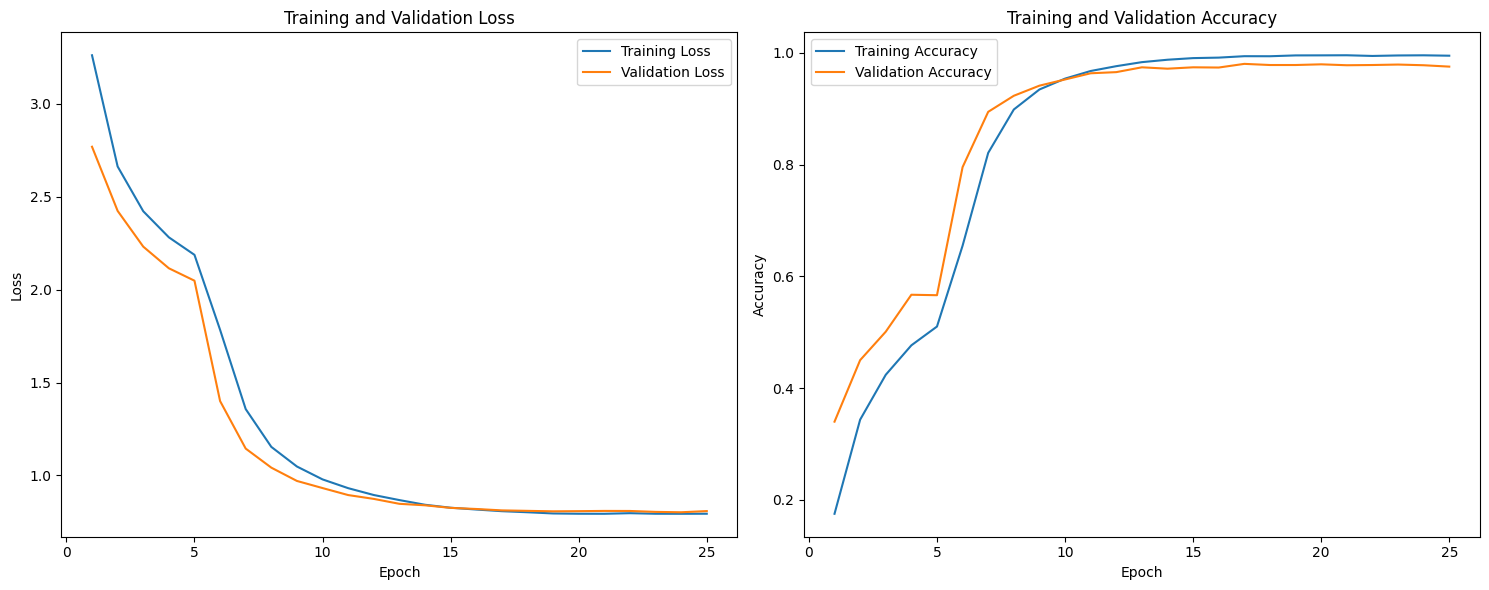

In [7]:
# ==============================================================================
# CELL 7: PLOT TRAINING HISTORY
# ==============================================================================
plt.figure(figsize=(15, 6))
epochs_range = range(1, EPOCHS + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


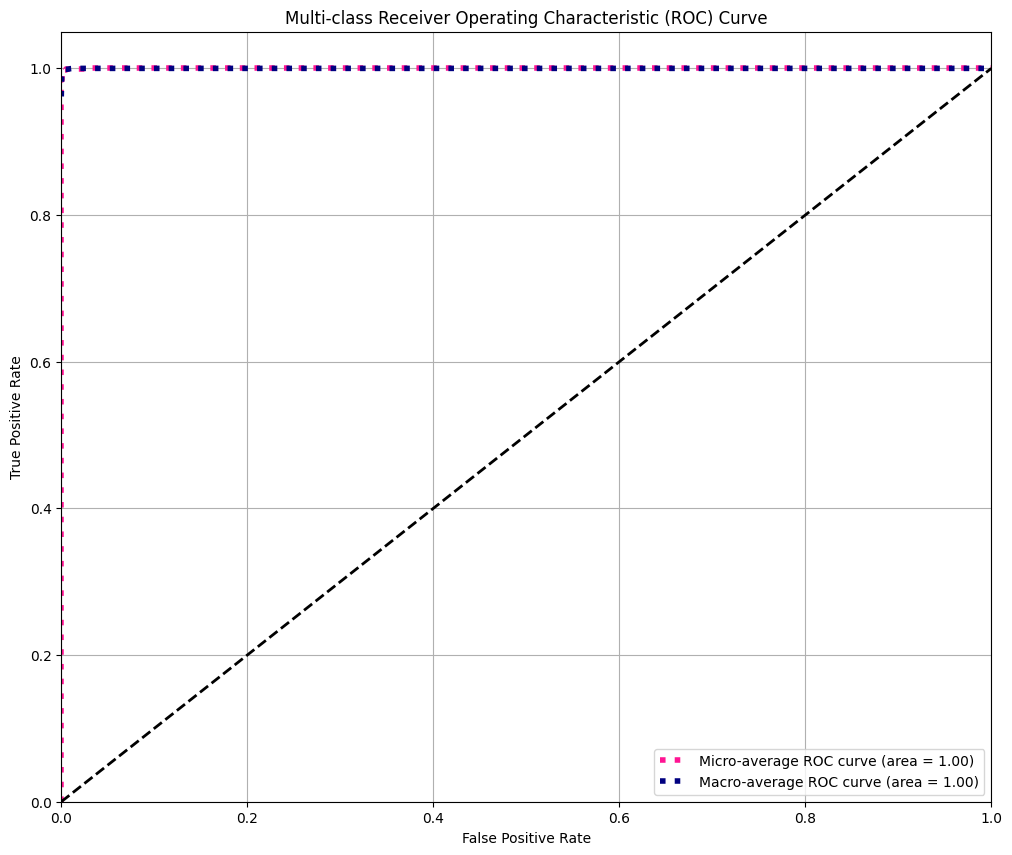

In [8]:
# ==============================================================================
# CELL 8: GET PREDICTIONS AND PLOT AUC/ROC CURVE
# ==============================================================================

@torch.no_grad()
def get_predictions_and_labels(model, loader):
    """Function to get model predictions and true labels."""
    model.eval()
    all_preds = []
    all_labels = []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        # Apply softmax to get probabilities
        probabilities = torch.nn.functional.softmax(logits, dim=1)
        all_preds.append(probabilities.cpu().numpy())
        all_labels.append(y.cpu().numpy())
    return np.vstack(all_preds), np.concatenate(all_labels)

# --- Get Predictions ---
y_pred_probs, y_true = get_predictions_and_labels(model, test_loader)
n_classes = len(class_names)

# --- Binarize the labels for multiclass ROC ---
y_true_binarized = label_binarize(y_true, classes=range(n_classes))

# --- Compute ROC curve and ROC area for each class ---
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# --- Compute micro-average ROC curve and ROC area ---
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binarized.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# --- Compute macro-average ROC curve and ROC area ---
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# --- Plot all ROC curves ---
plt.figure(figsize=(12, 10))

# Plot Micro-average ROC
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot Macro-average ROC
plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average ROC curve (area = {roc_auc["macro"]:0.2f})',
         color='navy', linestyle=':', linewidth=4)

# Optional: Plot ROC for a few classes if desired (plotting all 44 would be messy)
# colors = itertools.cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
# for i, color in zip(range(5), colors): # Plot first 5 classes
#     plt.plot(fpr[i], tpr[i], color=color, lw=2,
#              label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2) # Plot the "no-skill" line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Generating final report and confusion matrix on the TEST SET...

Classification Report:
                        precision    recall  f1-score   support

        Astrocitoma T1     0.9821    0.9821    0.9821        56
      Astrocitoma T1C+     1.0000    1.0000    1.0000        56
        Astrocitoma T2     0.9811    0.9286    0.9541        56
          Carcinoma T1     1.0000    0.9818    0.9908        55
        Carcinoma T1C+     1.0000    0.9818    0.9908        55
          Carcinoma T2     1.0000    1.0000    1.0000        55
         Ependimoma T1     0.9821    1.0000    0.9910        55
       Ependimoma T1C+     0.9818    0.9818    0.9818        55
         Ependimoma T2     1.0000    1.0000    1.0000        55
      Ganglioglioma T1     1.0000    1.0000    1.0000        56
    Ganglioglioma T1C+     1.0000    1.0000    1.0000        55
      Ganglioglioma T2     0.9655    1.0000    0.9825        56
          Germinoma T1     1.0000    1.0000    1.0000        55
        Germin

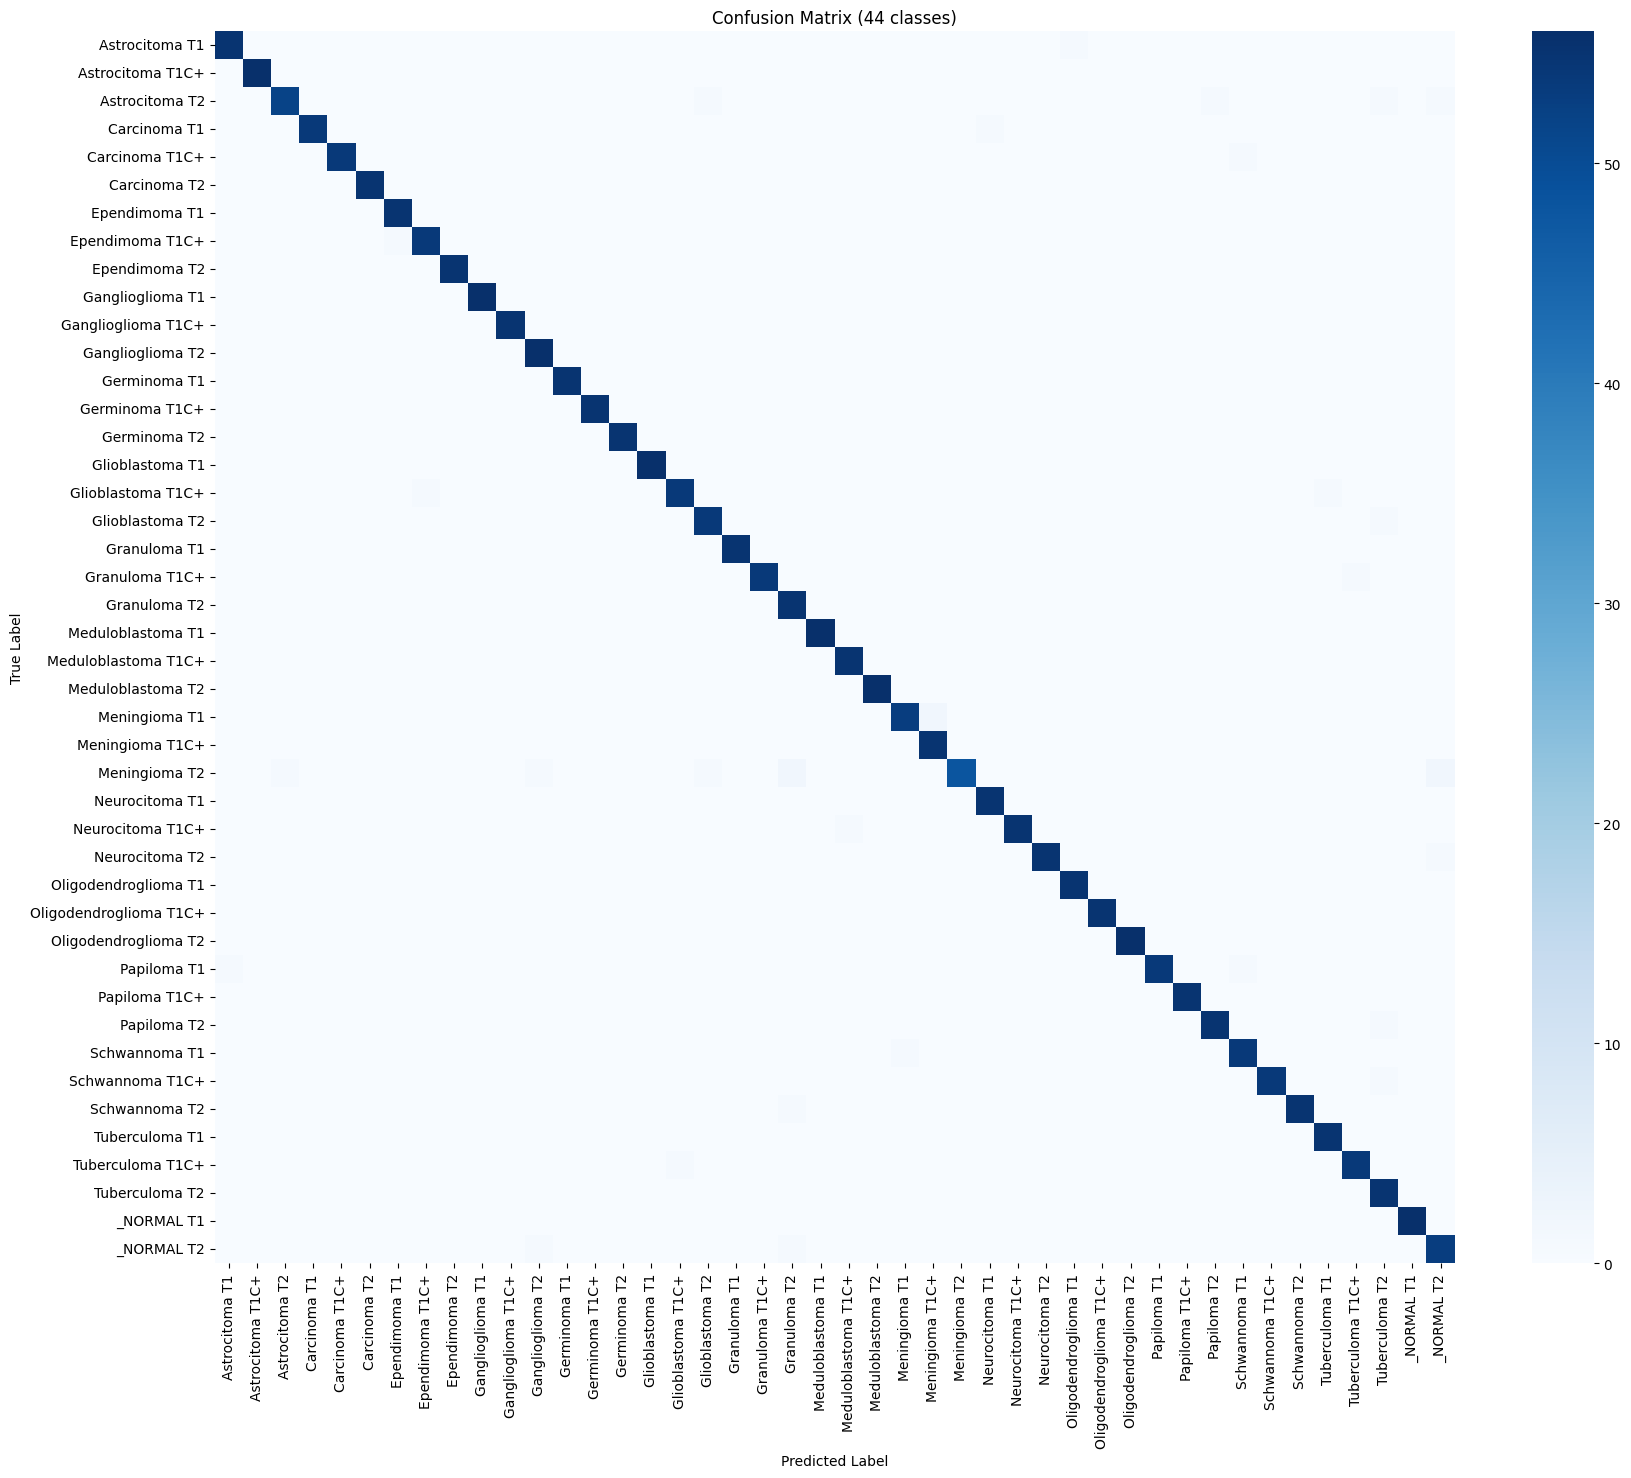

In [9]:
# ==============================================================================
# CELL 9: DETAILED REPORT AND CONFUSION MATRIX ON TEST SET
# ==============================================================================
print("\nGenerating final report and confusion matrix on the TEST SET...")
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=test_ds.classes, digits=4))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=test_ds.classes, yticklabels=test_ds.classes)
plt.title(f"Confusion Matrix ({len(test_ds.classes)} classes)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

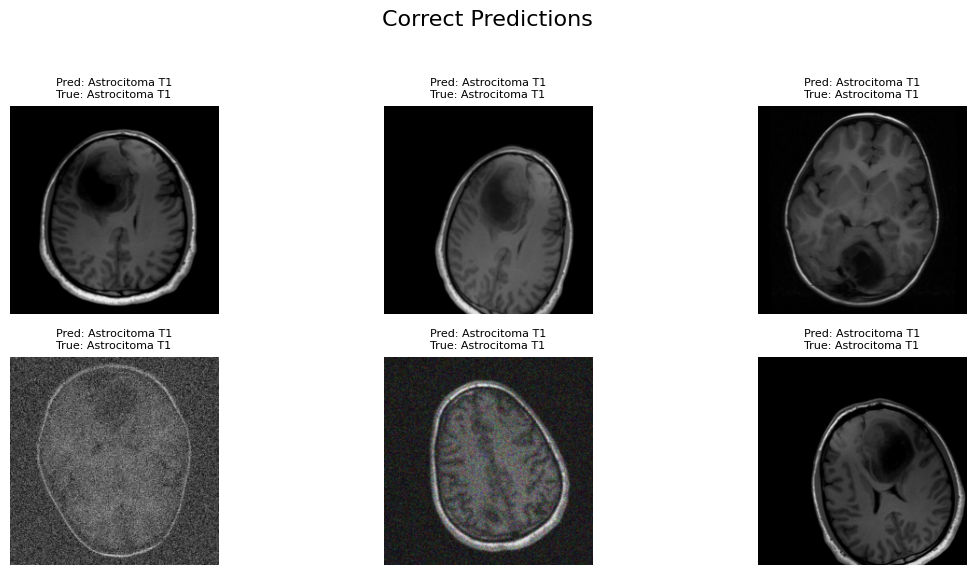

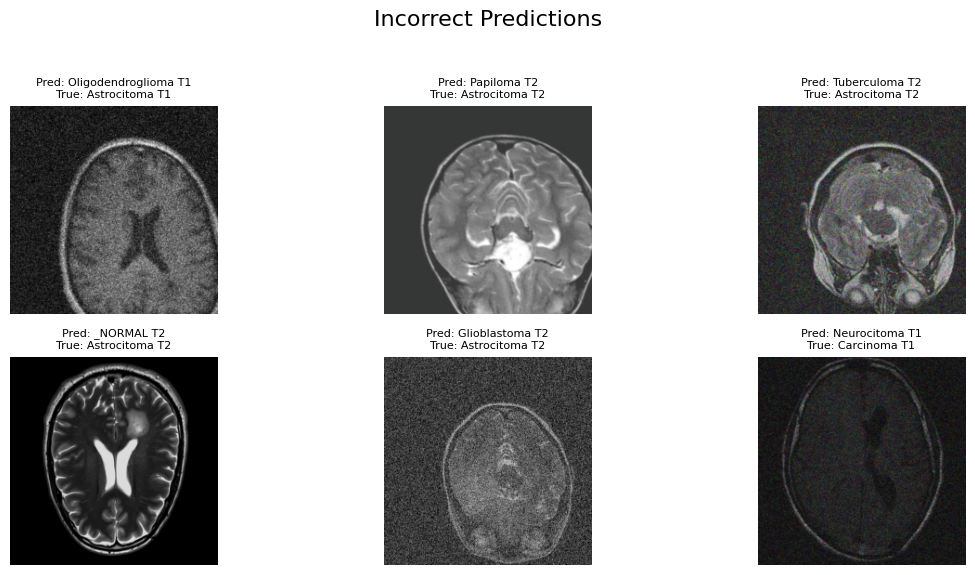

In [10]:
# ==============================================================================
# CELL 10: QUALITATIVE ANALYSIS (ERROR VISUALIZATION)
# ==============================================================================
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean, std = np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, fontsize=8)
    plt.axis('off')

correct_samples, incorrect_samples = [], []
num_to_show = 6

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images.to(device))
        _, preds = torch.max(outputs, 1)
        for i in range(images.size(0)):
            if len(correct_samples) < num_to_show and preds[i] == labels[i].to(device):
                correct_samples.append({'image': images[i], 'pred': preds[i].item(), 'true': labels[i].item()})
            elif len(incorrect_samples) < num_to_show and preds[i] != labels[i].to(device):
                incorrect_samples.append({'image': images[i], 'pred': preds[i].item(), 'true': labels[i].item()})
        if len(correct_samples) >= num_to_show and len(incorrect_samples) >= num_to_show:
            break

# --- Plot Correct Predictions ---
fig = plt.figure(figsize=(12, 6))
plt.suptitle("Correct Predictions", fontsize=16)
for i, sample in enumerate(correct_samples):
    ax = plt.subplot(2, 3, i + 1)
    title = f"Pred: {test_ds.classes[sample['pred']]}\nTrue: {test_ds.classes[sample['true']]}"
    imshow(sample['image'], title=title)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- Plot Incorrect Predictions ---
fig = plt.figure(figsize=(12, 6))
plt.suptitle("Incorrect Predictions", fontsize=16)
for i, sample in enumerate(incorrect_samples):
    ax = plt.subplot(2, 3, i + 1)
    title = f"Pred: {test_ds.classes[sample['pred']]}\nTrue: {test_ds.classes[sample['true']]}"
    imshow(sample['image'], title=title)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

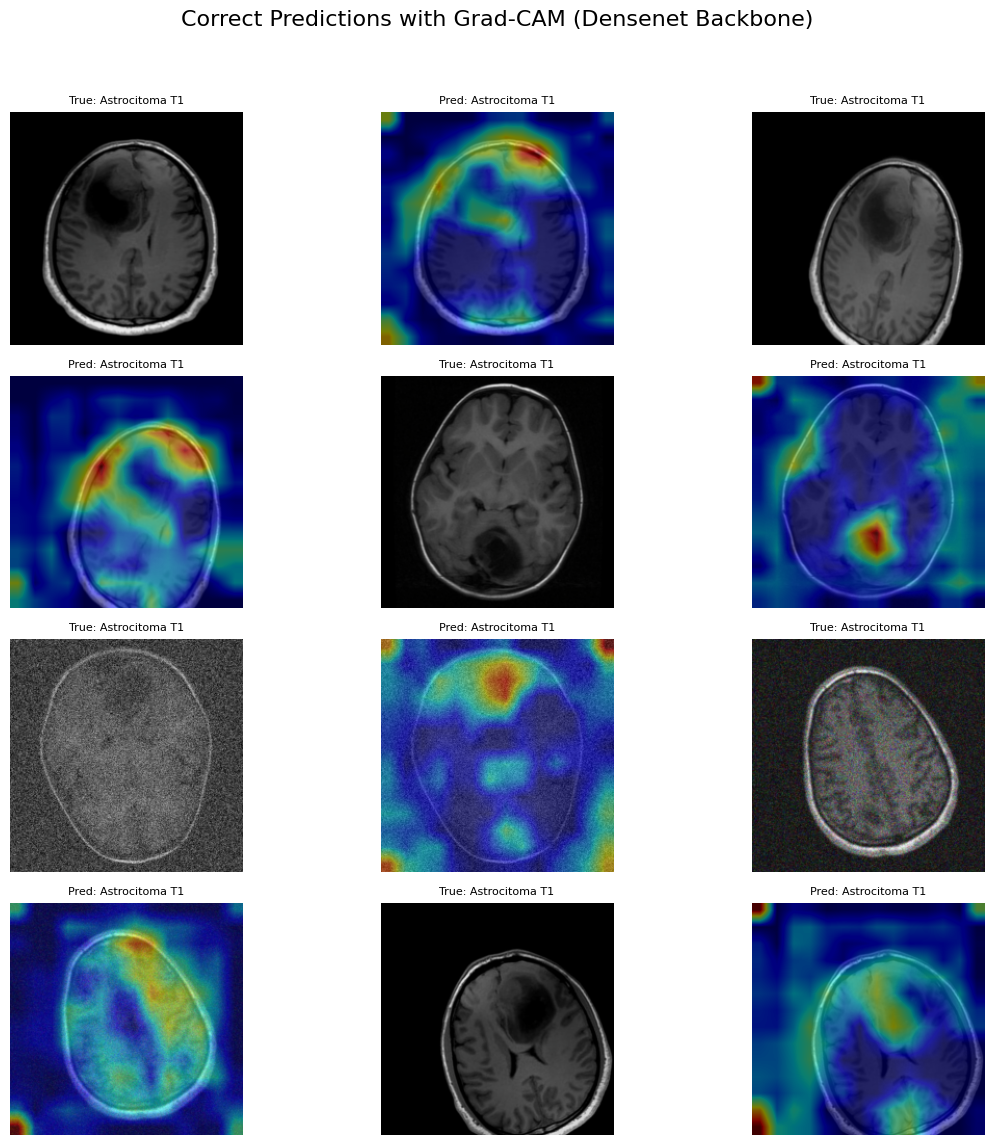

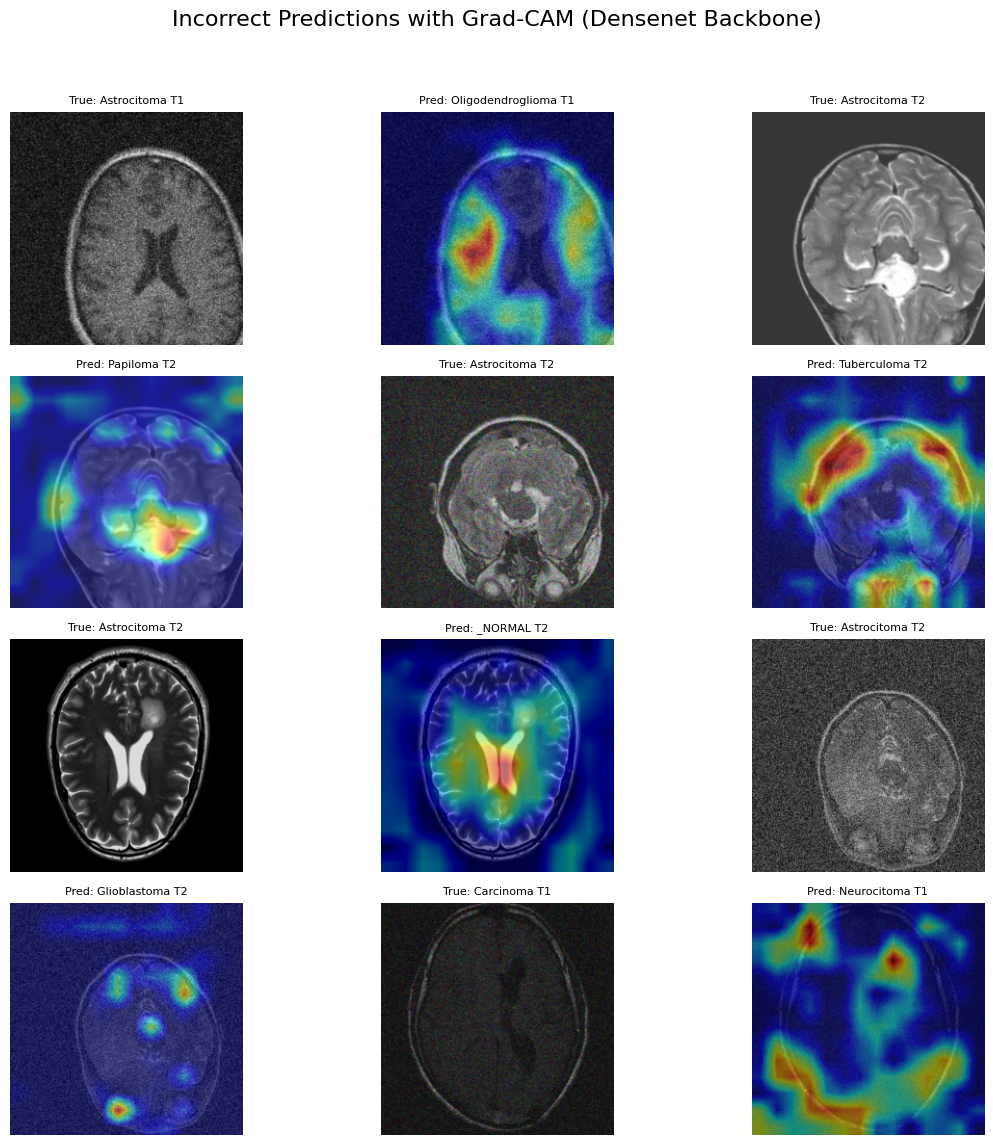

In [11]:
# ==============================================================================
# Cell 11: Grad-CAM for HybridCNN model (DenseNet or ResNet backbone)
# ==============================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def _find_last_conv_layer(model: nn.Module, backbone_name: str) -> nn.Module:
    """
    Find the last convolutional layer for a given backbone name in the model.
    """
    if backbone_name == "densenet":
        # Assuming DenseNet is exposed as .densenet in your HybridCNN
        if not hasattr(model, 'densenet'):
             raise AttributeError("Model does not have a 'densenet' attribute.")
        backbone = model.densenet.features
        # Find the last Conv2d layer in the DenseNet features
        for name, module in reversed(backbone._modules.items()):
            if isinstance(module, nn.Conv2d):
                return module
            # Look into sequential/block if the last layer isn't directly a Conv2d
            if isinstance(module, nn.Sequential) or isinstance(module, nn.ModuleList):
                 for sub_name, sub_module in reversed(module._modules.items()):
                     if isinstance(sub_module, nn.Conv2d):
                         return sub_module


    elif backbone_name == "resnet":
        # Assuming ResNet is exposed as .resnet in your HybridCNN
        if not hasattr(model, 'resnet'):
            raise AttributeError("Model does not have a 'resnet' attribute.")
        backbone = model.resnet
        # Find the last Conv2d layer in the ResNet (e.g., in layer4)
        # This might need adjustment based on the specific ResNet architecture
        # For ResNet50, the last block is `layer4`. The last conv is in the last bottleneck.
        if hasattr(backbone, 'layer4') and len(backbone.layer4) > 0:
            last_block = backbone.layer4[-1]
            for name, module in reversed(last_block._modules.items()):
                 if isinstance(module, nn.Conv2d):
                     return module
        # Fallback: Search all modules if specific layer is not found
        for name, module in reversed(backbone._modules.items()):
            if isinstance(module, nn.Conv2d):
                return module
            if isinstance(module, nn.Sequential) or isinstance(module, nn.ModuleList):
                 for sub_name, sub_module in reversed(module._modules.items()):
                     if isinstance(sub_module, nn.Conv2d):
                         return sub_module
    else:
        raise ValueError(f"Unknown backbone name: {backbone_name}. Choose 'densenet' or 'resnet'.")

    raise RuntimeError(f"Could not locate the last Conv2d layer for backbone {backbone_name}.")


class GradCAM:
    def __init__(self, model: nn.Module, target_layer: nn.Module):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None

        # --- Register hooks to capture activations and gradients ---
        def fwd_hook_capture(module, inp, out):
            self.activations = out.requires_grad_(True)

        def bwd_hook_capture(module, grad_input, grad_output):
            self.gradients = grad_output[0] # Capture gradient w.r.t. output of the layer

        self.fwd_hook = self.target_layer.register_forward_hook(fwd_hook_capture)
        self.bwd_hook = self.target_layer.register_full_backward_hook(bwd_hook_capture)


    def generate(self, x: torch.Tensor, class_idx: int | None = None):
        """
        x: (1, C, H, W) tensor on the same device as model.
        Returns: (H, W) numpy heatmap in [0,1).
        """
        self.model.eval()
        self.activations = None # Reset activations and gradients
        self.gradients = None

        # --- Forward pass ---
        logits = self.model(x)

        # --- Select the score for the target class ---
        if class_idx is None:
            class_idx = int(torch.argmax(logits, dim=1).item())
        score = logits[:, class_idx]

        # --- Perform backward pass to calculate gradients ---
        self.model.zero_grad(set_to_none=True)
        score.backward(retain_graph=True) # Use retain_graph=True if you plan more backward passes

        # --- Check if activations and gradients were captured ---
        if self.activations is None:
             raise RuntimeError("Activations not captured. Check target_layer.")
        if self.gradients is None:
            raise RuntimeError("Gradients not captured. Ensure hooks are registered and backward pass is called correctly.")


        # GAP over spatial dims to get channel weights
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)       # (B,K,1,1)

        # Weighted sum of activations
        cam = (weights * self.activations.detach()).sum(dim=1, keepdim=True)   # (B,1,h,w)
        cam = F.relu(cam) # Apply ReLU

        # Interpolate to original image size and normalize
        cam = F.interpolate(cam, size=x.shape[2:], mode="bilinear", align_corners=False)
        cam = cam.squeeze().detach().cpu().float().numpy()

        # Normalize to [0, 1]
        cam -= cam.min()
        cam /= (cam.max() + 1e-8)

        return cam

    def __del__(self):
        """Remove hooks when the object is deleted."""
        self.fwd_hook.remove()
        self.bwd_hook.remove()


def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean, std = np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, fontsize=8)
    plt.axis('off')
    return inp # Return the processed image array


# --- Qualitative Analysis (Error Visualization) ---
correct_samples, incorrect_samples = [], []
num_to_show = 6 # Number of correct/incorrect images to show

# Load the best model
model.load_state_dict(torch.load(best_path)["state_dict"])
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


with torch.no_grad():
    for images, labels in test_loader:
        images_gpu = images.to(device)
        outputs = model(images_gpu)
        _, preds = torch.max(outputs, 1)
        for i in range(images.size(0)):
            if len(correct_samples) < num_to_show and preds[i] == labels[i].to(device):
                correct_samples.append({'image': images[i].cpu(), 'pred': preds[i].item(), 'true': labels[i].item()})
            elif len(incorrect_samples) < num_to_show and preds[i] != labels[i].to(device):
                incorrect_samples.append({'image': images[i].cpu(), 'pred': preds[i].item(), 'true': labels[i].item()})
        if len(correct_samples) >= num_to_show and len(incorrect_samples) >= num_to_show:
            break

# ---- Build Grad-CAM using your wrapped model ----
# Choose which backbone to visualize CAM for: 'densenet' or 'resnet'
BACKBONE_TO_VISUALIZE = 'densenet' # <--- CHANGE THIS TO 'resnet' TO SEE RESNET CAM

try:
    target_layer = _find_last_conv_layer(model, BACKBONE_TO_VISUALIZE)
    grad_cam = GradCAM(model, target_layer)
except (AttributeError, RuntimeError, ValueError) as e:
    print(f"Error setting up Grad-CAM: {e}")
    grad_cam = None # Disable CAM if setup fails


if grad_cam:
    # --- Plot Correct Predictions with Grad-CAM ---
    fig = plt.figure(figsize=(12, 12))
    plt.suptitle(f"Correct Predictions with Grad-CAM ({BACKBONE_TO_VISUALIZE.capitalize()} Backbone)", fontsize=16)
    for i, sample in enumerate(correct_samples):
        ax = plt.subplot(num_to_show // 3 * 2, 3, i * 2 + 1) # Adjust subplot grid
        title = f"True: {test_ds.classes[sample['true']]}"
        imshow(sample['image'], title=title)

        ax = plt.subplot(num_to_show // 3 * 2, 3, i * 2 + 2) # Adjust subplot grid
        # Pass image to GPU for CAM generation
        heatmap = grad_cam.generate(sample['image'].unsqueeze(0).to(device))
        plt.title(f"Pred: {test_ds.classes[sample['pred']]}", fontsize=8)
        plt.axis("off")
        imshow(sample['image']) # Plot original image again
        plt.imshow(heatmap, cmap="jet", alpha=0.5) # Overlay heatmap

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # --- Plot Incorrect Predictions with Grad-CAM ---
    fig = plt.figure(figsize=(12, 12))
    plt.suptitle(f"Incorrect Predictions with Grad-CAM ({BACKBONE_TO_VISUALIZE.capitalize()} Backbone)", fontsize=16)
    for i, sample in enumerate(incorrect_samples):
        ax = plt.subplot(num_to_show // 3 * 2, 3, i * 2 + 1) # Adjust subplot grid
        title = f"True: {test_ds.classes[sample['true']]}"
        imshow(sample['image'], title=title)

        ax = plt.subplot(num_to_show // 3 * 2, 3, i * 2 + 2) # Adjust subplot grid
        # Pass image to GPU for CAM generation
        heatmap = grad_cam.generate(sample['image'].unsqueeze(0).to(device))
        plt.title(f"Pred: {test_ds.classes[sample['pred']]}", fontsize=8)
        plt.axis("off")
        imshow(sample['image']) # Plot original image again
        plt.imshow(heatmap, cmap="jet", alpha=0.5) # Overlay heatmap

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print("\nSkipping Grad-CAM visualization due to setup errors.")
    # If Grad-CAM setup failed, still show the images without heatmaps
    print("Plotting Correct Predictions (without Grad-CAM):")
    fig = plt.figure(figsize=(12, 6))
    plt.suptitle("Correct Predictions", fontsize=16)
    for i, sample in enumerate(correct_samples):
        ax = plt.subplot(2, 3, i + 1)
        title = f"Pred: {test_ds.classes[sample['pred']]}\nTrue: {test_ds.classes[sample['true']]}"
        imshow(sample['image'], title=title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    print("\nPlotting Incorrect Predictions (without Grad-CAM):")
    fig = plt.figure(figsize=(12, 6))
    plt.suptitle("Incorrect Predictions", fontsize=16)
    for i, sample in enumerate(incorrect_samples):
        ax = plt.subplot(2, 3, i + 1)
        title = f"Pred: {test_ds.classes[sample['pred']]}\nTrue: {test_ds.classes[sample['true']]}"
        imshow(sample['image'], title=title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()